# MTF and DQE in Electron Microscopy: A Practical Introduction

The Modulation Transfer Function (MTF) and Detective Quantum Efficiency (DQE) are crucial metrics for evaluating the performance of imaging systems in electron microscopy.
When we talk about transforming an image to the frequency domain, we're referring to decomposing it into its constituent spatial frequencies using mathematical techniques like the Fourier Transform. This allows us to analyze how well the microscope system preserves different spatial frequencies (details) from the specimen to the final image.

**MTF** measures how faithfully the imaging system transfers contrast from the specimen to the image across different spatial frequencies. A perfect imaging system would have an MTF of 1 at all frequencies, but real systems show a decline at higher frequencies (finer details).

**DQE** measures the efficiency with which the detector converts incoming electrons into useful signal, accounting for noise. It's essentially a signal-to-noise ratio normalized to the input signal and is frequency-dependent.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.fft import fft2, fftshift, ifft2, ifftshift
from skimage import exposure
from skimage import io
from numpy.random import poisson

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Understanding the Frequency Domain

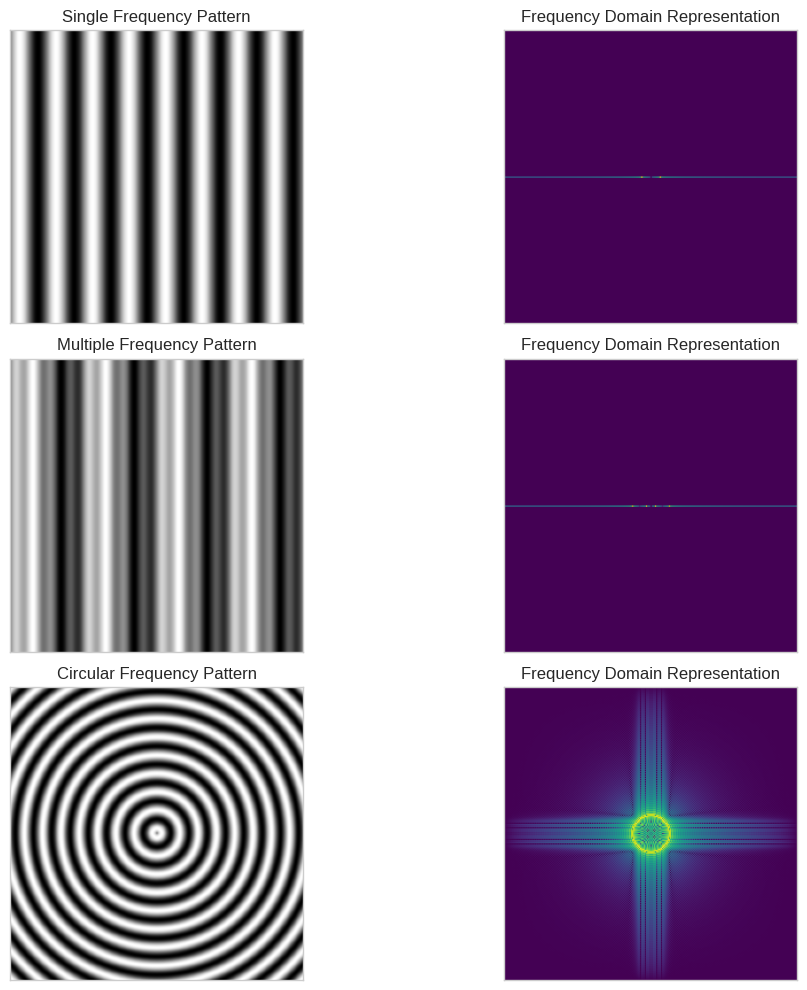

Note how a single-frequency sine wave appears as two bright dots in the Fourier domain.
The multiple frequency pattern shows additional dots at different distances from the center.
The circular pattern transforms into rings in the frequency domain.

The distance from the center represents frequency (higher = finer details).
The brightness represents the amplitude of that frequency component.


In [17]:
def plot_frequency_domain():
    """Demonstrate transformation of simple patterns to frequency domain"""
    
    # Create some test patterns
    size = 256
    x = np.linspace(-4, 4, size)
    y = np.linspace(-4, 4, size)
    X, Y = np.meshgrid(x, y)
    
    # Pattern 1: Single frequency sine wave
    frequency = 8  # cycles across the image
    sine_pattern = np.sin(2 * np.pi * frequency * X / 8)
    
    # Pattern 2: Multiple frequency pattern
    multi_freq = np.sin(2 * np.pi * 4 * X / 8) + 0.5 * np.sin(2 * np.pi * 16 * X / 8)
    
    # Pattern 3: Circular pattern (like a zone plate)
    circle_pattern = np.sin(2 * np.pi * np.sqrt(X**2 + Y**2) / 0.5)
    
    # Transform patterns to frequency domain
    sine_fft = fftshift(fft2(sine_pattern))
    multi_fft = fftshift(fft2(multi_freq))
    circle_fft = fftshift(fft2(circle_pattern))
    
    # Plot in spatial and frequency domains
    fig, axs = plt.subplots(3, 2, figsize=(12, 10))
    
    axs[0, 0].imshow(sine_pattern, cmap='gray')
    axs[0, 0].set_title('Single Frequency Pattern')
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticks([])
    
    axs[0, 1].imshow(np.log1p(np.abs(sine_fft)), cmap='viridis')
    axs[0, 1].set_title('Frequency Domain Representation')
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])
    
    axs[1, 0].imshow(multi_freq, cmap='gray')
    axs[1, 0].set_title('Multiple Frequency Pattern')
    axs[1, 0].set_xticks([])
    axs[1, 0].set_yticks([])
    
    axs[1, 1].imshow(np.log1p(np.abs(multi_fft)), cmap='viridis')
    axs[1, 1].set_title('Frequency Domain Representation')
    axs[1, 1].set_xticks([])
    axs[1, 1].set_yticks([])
    
    axs[2, 0].imshow(circle_pattern, cmap='gray')
    axs[2, 0].set_title('Circular Frequency Pattern')
    axs[2, 0].set_xticks([])
    axs[2, 0].set_yticks([])
    
    axs[2, 1].imshow(np.log1p(np.abs(circle_fft)), cmap='viridis')
    axs[2, 1].set_title('Frequency Domain Representation')
    axs[2, 1].set_xticks([])
    axs[2, 1].set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    print("Note how a single-frequency sine wave appears as two bright dots in the Fourier domain.")
    print("The multiple frequency pattern shows additional dots at different distances from the center.")
    print("The circular pattern transforms into rings in the frequency domain.")
    print("\nThe distance from the center represents frequency (higher = finer details).")
    print("The brightness represents the amplitude of that frequency component.")

# Execute the function
plot_frequency_domain()

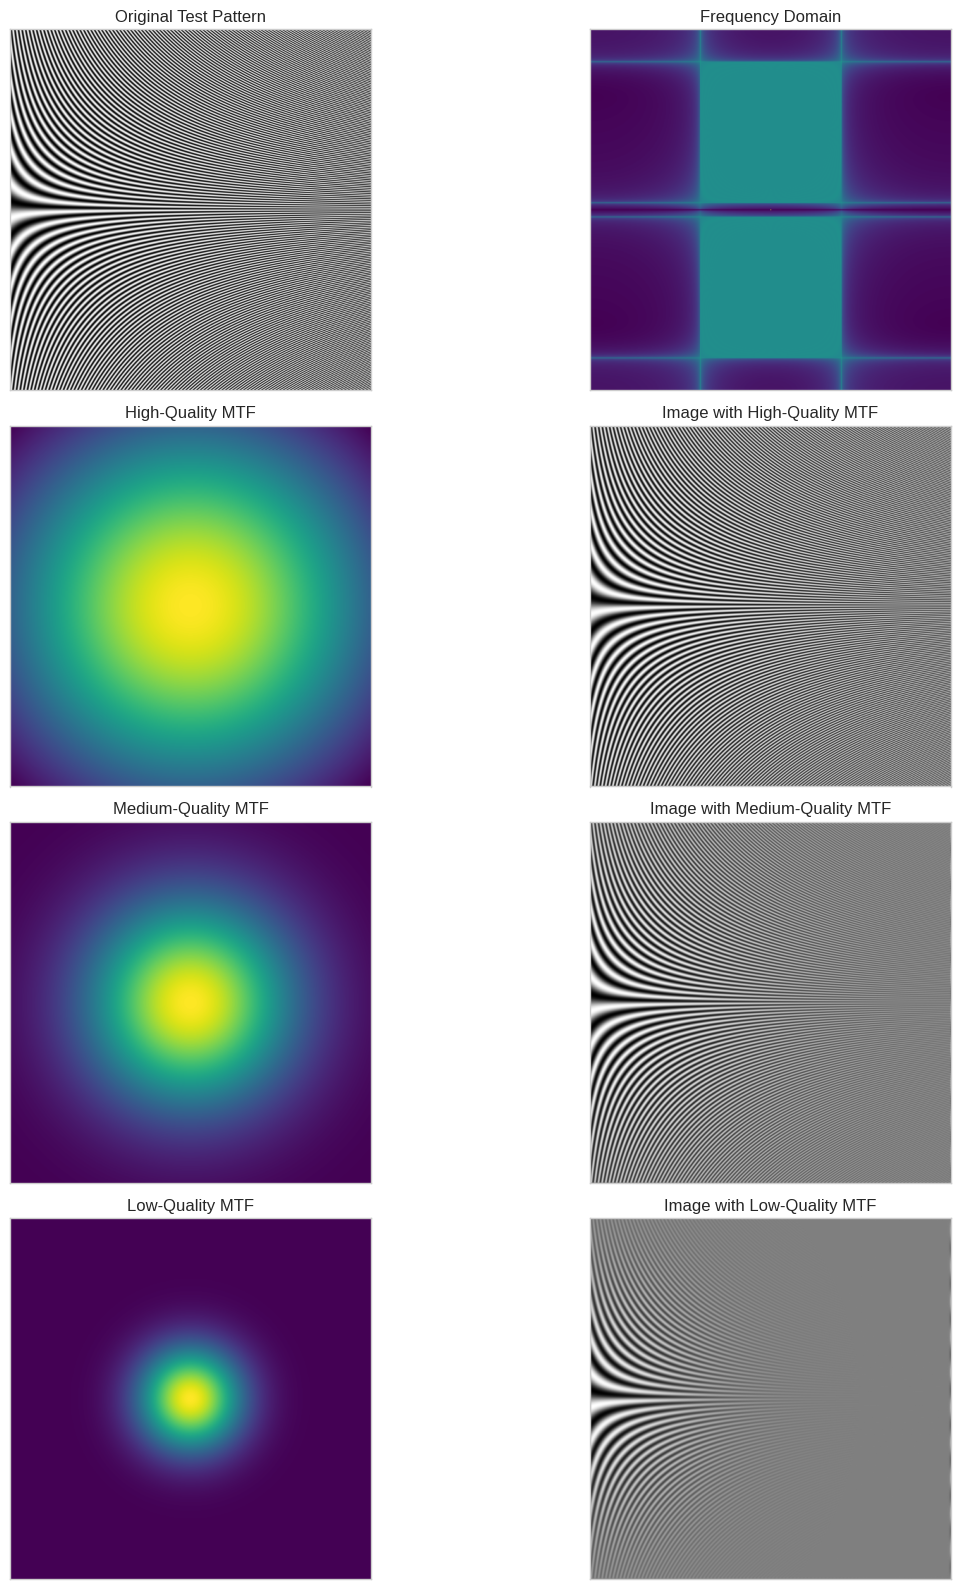

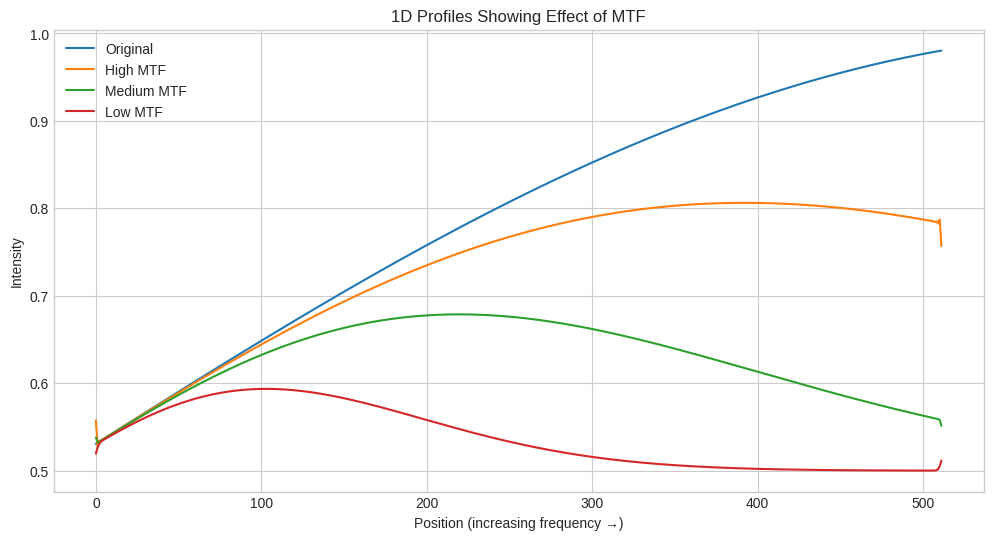

The MTF acts as a frequency filter in the imaging system.
Notice how higher frequencies (finer details on the right side) are more affected.
A good imaging system (high MTF) preserves more of the high-frequency details.


In [18]:
# 2. Simulating a Simple Imaging System with MTF

def simulate_imaging_with_mtf():
    """Demonstrate the effects of MTF on image quality"""
    
    # Create a test pattern with a range of spatial frequencies
    size = 512
    x = np.linspace(-10, 10, size)
    y = np.linspace(-10, 10, size)
    X, Y = np.meshgrid(x, y)
    
    # Create a pattern that has increasing frequency from left to right
    test_pattern = np.zeros((size, size))
    for i in range(size):
        frequency = 0.5 + (i / size) * 10  # frequency increases with column index
        test_pattern[:, i] = 0.5 + 0.5 * np.sin(2 * np.pi * frequency * y)
    
    # Transform to frequency domain
    pattern_fft = fftshift(fft2(test_pattern))
    
    # Create MTF functions with different cutoff frequencies
    def create_mtf(cutoff_freq):
        freq_x = np.linspace(-size/2, size/2, size) / size
        freq_y = np.linspace(-size/2, size/2, size) / size
        FX, FY = np.meshgrid(freq_x, freq_y)
        freq_radius = np.sqrt(FX**2 + FY**2)
        
        # Gaussian MTF model
        mtf = np.exp(-(freq_radius**2) / (2 * cutoff_freq**2))
        return mtf
    
    # Apply MTFs with different cutoffs
    mtf_high = create_mtf(0.4)  # Good MTF
    mtf_medium = create_mtf(0.2)  # Medium MTF
    mtf_low = create_mtf(0.1)  # Poor MTF
    
    # Apply MTFs in frequency domain
    result_high = ifft2(ifftshift(pattern_fft * mtf_high)).real
    result_medium = ifft2(ifftshift(pattern_fft * mtf_medium)).real
    result_low = ifft2(ifftshift(pattern_fft * mtf_low)).real
    
    # Plot original pattern and results with different MTFs
    fig, axs = plt.subplots(4, 2, figsize=(14, 16))
    
    # Original pattern
    axs[0, 0].imshow(test_pattern, cmap='gray')
    axs[0, 0].set_title('Original Test Pattern')
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticks([])
    
    # Frequency domain of original
    axs[0, 1].imshow(np.log1p(np.abs(pattern_fft)), cmap='viridis')
    axs[0, 1].set_title('Frequency Domain')
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])
    
    # Different MTFs and their effects
    axs[1, 0].imshow(mtf_high, cmap='viridis')
    axs[1, 0].set_title('High-Quality MTF')
    axs[1, 0].set_xticks([])
    axs[1, 0].set_yticks([])
    
    axs[1, 1].imshow(result_high, cmap='gray')
    axs[1, 1].set_title('Image with High-Quality MTF')
    axs[1, 1].set_xticks([])
    axs[1, 1].set_yticks([])
    
    axs[2, 0].imshow(mtf_medium, cmap='viridis')
    axs[2, 0].set_title('Medium-Quality MTF')
    axs[2, 0].set_xticks([])
    axs[2, 0].set_yticks([])
    
    axs[2, 1].imshow(result_medium, cmap='gray')
    axs[2, 1].set_title('Image with Medium-Quality MTF')
    axs[2, 1].set_xticks([])
    axs[2, 1].set_yticks([])
    
    axs[3, 0].imshow(mtf_low, cmap='viridis')
    axs[3, 0].set_title('Low-Quality MTF')
    axs[3, 0].set_xticks([])
    axs[3, 0].set_yticks([])
    
    axs[3, 1].imshow(result_low, cmap='gray')
    axs[3, 1].set_title('Image with Low-Quality MTF')
    axs[3, 1].set_xticks([])
    axs[3, 1].set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    # Plot 1D profiles to better see the effect
    plt.figure(figsize=(12, 6))
    row = size // 2
    plt.plot(test_pattern[row, :], label='Original')
    plt.plot(result_high[row, :], label='High MTF')
    plt.plot(result_medium[row, :], label='Medium MTF')
    plt.plot(result_low[row, :], label='Low MTF')
    plt.legend()
    plt.title('1D Profiles Showing Effect of MTF')
    plt.xlabel('Position (increasing frequency →)')
    plt.ylabel('Intensity')
    plt.show()
    
    print("The MTF acts as a frequency filter in the imaging system.")
    print("Notice how higher frequencies (finer details on the right side) are more affected.")
    print("A good imaging system (high MTF) preserves more of the high-frequency details.")

# Execute the function
simulate_imaging_with_mtf()

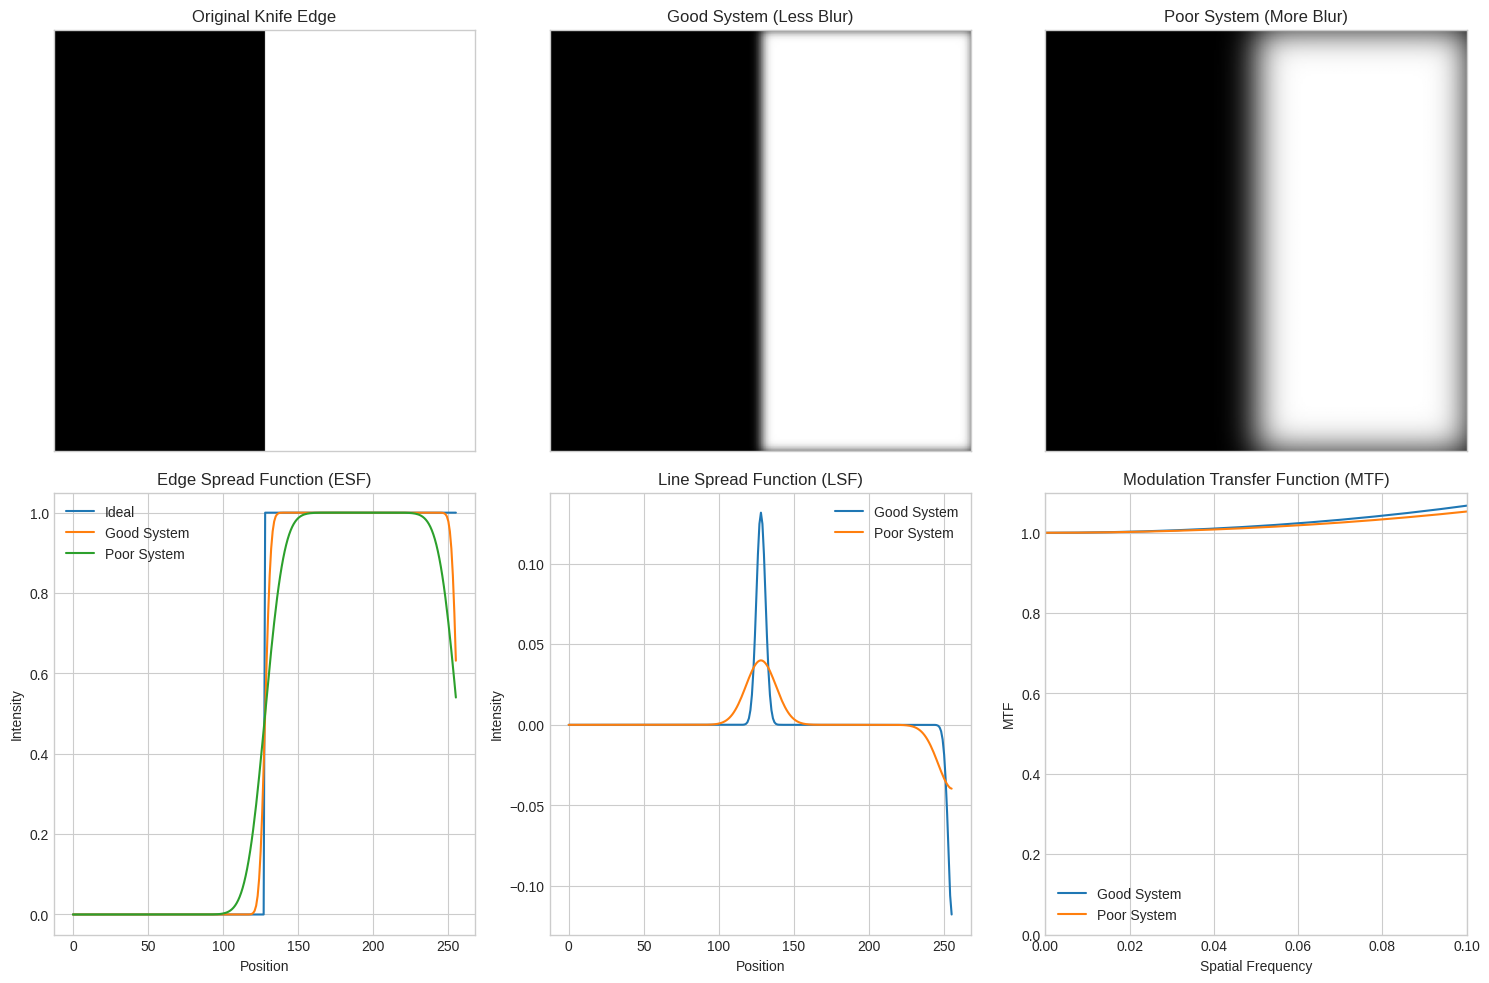

The knife-edge method is commonly used to measure MTF:
1. Image a sharp edge (knife-edge)
2. Extract the Edge Spread Function (ESF) - intensity profile across the edge
3. Differentiate to get the Line Spread Function (LSF)
4. Take the Fourier Transform of the LSF to get the MTF

Notice how the better system preserves more high-frequency information (MTF falls off more slowly)


In [10]:
# 3. Understanding and Measuring MTF - Memory-Optimized Version

def simulate_knife_edge_measurement():
    """Simulate knife-edge method for MTF measurement with memory optimization"""
    
    # Create a knife-edge (step function) image with a smaller size
    size = 256  # Reduced from 512
    knife_edge = np.zeros((size, size))
    knife_edge[:, size//2:] = 1
    
    # Create MTFs with different quality
    x = np.linspace(-size/2, size/2, size)
    sigma_good = 3
    sigma_poor = 10
    
    # Create PSFs (Point Spread Functions) - 1D to save memory
    psf_good = np.exp(-x**2 / (2 * sigma_good**2))
    psf_poor = np.exp(-x**2 / (2 * sigma_poor**2))
    psf_good = psf_good / np.sum(psf_good)  # Normalize
    psf_poor = psf_poor / np.sum(psf_poor)  # Normalize
    
    # Create 2D PSFs with smaller memory footprint
    # We'll use separable convolution instead of creating full 2D PSFs
    
    # Apply PSFs to knife-edge using separate 1D convolutions
    # First convolve horizontally
    knife_edge_good_h = np.zeros_like(knife_edge)
    knife_edge_poor_h = np.zeros_like(knife_edge)
    
    for i in range(size):
        knife_edge_good_h[i] = np.convolve(knife_edge[i], psf_good, mode='same')
        knife_edge_poor_h[i] = np.convolve(knife_edge[i], psf_poor, mode='same')
    
    # Then convolve vertically (since our PSF is symmetric, we can reuse it)
    knife_edge_good = np.zeros_like(knife_edge)
    knife_edge_poor = np.zeros_like(knife_edge)
    
    for j in range(size):
        knife_edge_good[:, j] = np.convolve(knife_edge_good_h[:, j], psf_good, mode='same')
        knife_edge_poor[:, j] = np.convolve(knife_edge_poor_h[:, j], psf_poor, mode='same')
    
    # Calculate Edge Spread Function (ESF) - average along the edge
    esf_ideal = knife_edge[size//2, :]
    esf_good = knife_edge_good[size//2, :]
    esf_poor = knife_edge_poor[size//2, :]
    
    # Calculate Line Spread Function (LSF) - derivative of ESF
    lsf_good = np.gradient(esf_good)
    lsf_poor = np.gradient(esf_poor)
    
    # Calculate MTF - normalized FFT of LSF
    mtf_good = np.abs(np.fft.fftshift(np.fft.fft(lsf_good)))
    mtf_poor = np.abs(np.fft.fftshift(np.fft.fft(lsf_poor)))
    
    # Normalize MTFs
    mtf_good = mtf_good / mtf_good[size//2]
    mtf_poor = mtf_poor / mtf_poor[size//2]
    
    # Plot results
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original and blurred knife edges
    axs[0, 0].imshow(knife_edge, cmap='gray')
    axs[0, 0].set_title('Original Knife Edge')
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticks([])
    
    axs[0, 1].imshow(knife_edge_good, cmap='gray')
    axs[0, 1].set_title('Good System (Less Blur)')
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])
    
    axs[0, 2].imshow(knife_edge_poor, cmap='gray')
    axs[0, 2].set_title('Poor System (More Blur)')
    axs[0, 2].set_xticks([])
    axs[0, 2].set_yticks([])
    
    # Edge Spread Functions
    axs[1, 0].plot(esf_ideal, label='Ideal')
    axs[1, 0].plot(esf_good, label='Good System')
    axs[1, 0].plot(esf_poor, label='Poor System')
    axs[1, 0].set_title('Edge Spread Function (ESF)')
    axs[1, 0].legend()
    axs[1, 0].set_xlabel('Position')
    axs[1, 0].set_ylabel('Intensity')
    
    # Line Spread Functions
    axs[1, 1].plot(lsf_good, label='Good System')
    axs[1, 1].plot(lsf_poor, label='Poor System')
    axs[1, 1].set_title('Line Spread Function (LSF)')
    axs[1, 1].legend()
    axs[1, 1].set_xlabel('Position')
    axs[1, 1].set_ylabel('Intensity')
    
    # MTF
    frequencies = np.fft.fftfreq(size)[:size//2]
    mtf_good_plot = mtf_good[:size//2]
    mtf_poor_plot = mtf_poor[:size//2]
    
    axs[1, 2].plot(frequencies, mtf_good_plot / mtf_good_plot[0], label='Good System')
    axs[1, 2].plot(frequencies, mtf_poor_plot / mtf_poor_plot[0], label='Poor System')
    axs[1, 2].set_title('Modulation Transfer Function (MTF)')
    axs[1, 2].legend()
    axs[1, 2].set_xlabel('Spatial Frequency')
    axs[1, 2].set_ylabel('MTF')
    axs[1, 2].set_xlim(0, 0.1)  # Focus on lower frequencies for clarity
    axs[1, 2].set_ylim(0, 1.1)
    
    plt.tight_layout()
    plt.show()
    
    print("The knife-edge method is commonly used to measure MTF:")
    print("1. Image a sharp edge (knife-edge)")
    print("2. Extract the Edge Spread Function (ESF) - intensity profile across the edge")
    print("3. Differentiate to get the Line Spread Function (LSF)")
    print("4. Take the Fourier Transform of the LSF to get the MTF")
    print("\nNotice how the better system preserves more high-frequency information (MTF falls off more slowly)")

# Here are memory optimization tips for the other functions:

def memory_optimization_tips():
    print("Memory Optimization Tips for Other Functions in the Tutorial:")
    print("\n1. Reduce image sizes:")
    print("   - Change size = 512 to size = 256 or smaller in all functions")
    print("   - This reduces memory usage by 75% when going from 512 to 256")
    
    print("\n2. Avoid large 2D convolutions:")
    print("   - Use separable convolutions when possible (horizontal then vertical)")
    print("   - Or use scipy's signal.fftconvolve with mode='same' which can be more memory efficient")
    
    print("\n3. Clean up large arrays when no longer needed:")
    print("   - Use 'del variable_name' to release memory")
    print("   - For example: del knife_edge_good_h after it's no longer needed")
    
    print("\n4. Use float32 instead of float64 when precision isn't critical:")
    print("   - Add .astype(np.float32) to array creation")
    print("   - Example: np.zeros((size, size), dtype=np.float32)")
    
    print("\n5. For the DQE simulation functions:")
    print("   - Process one row at a time instead of full images")
    print("   - Or reduce the number of dose levels tested")
    
    print("\n6. For MTF correction demo:")
    print("   - Reduce the number of correction parameters tested")
    print("   - Process smaller regions of interest when possible")
    
    print("\n7. General tips:")
    print("   - Restart your kernel before running memory-intensive code")
    print("   - Monitor memory usage while running")
    print("   - Consider using a machine with more RAM or cloud computing resources")

simulate_knife_edge_measurement()

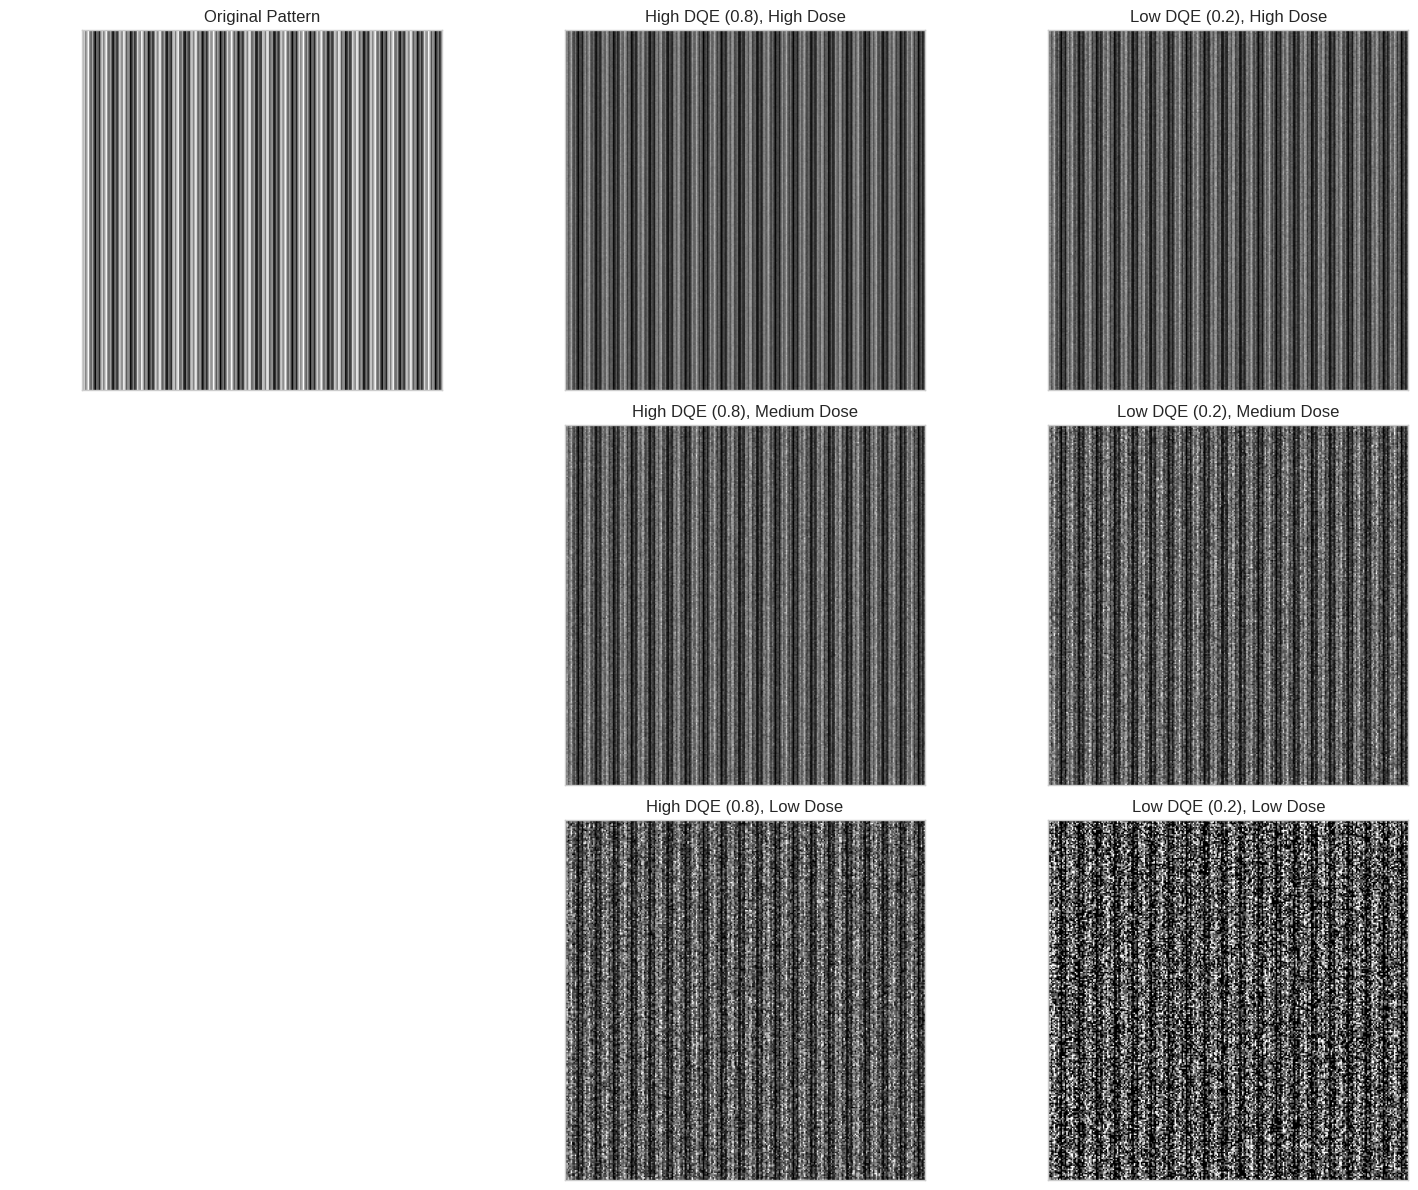

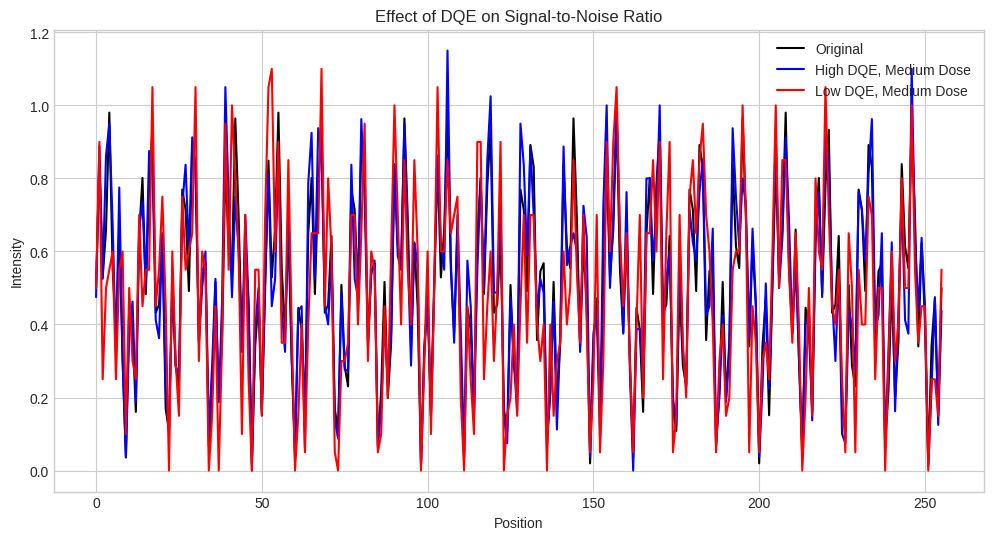

DQE measures the efficiency of the detector in converting electrons to signal.
A high DQE detector (closer to 1.0) produces higher signal-to-noise ratio images.
This is especially important at low electron doses (beam-sensitive samples).

At high doses, even a low DQE detector can produce acceptable images.
But at low doses, a high DQE detector makes a critical difference.


In [11]:
# 4. Detective Quantum Efficiency (DQE)

def simulate_dqe():
    """Demonstrate DQE and its impact on image quality"""
    
    # Create a simple test pattern
    size = 256
    x = np.linspace(-5, 5, size)
    y = np.linspace(-5, 5, size)
    X, Y = np.meshgrid(x, y)
    
    # Pattern with two frequencies
    pattern = 0.5 + 0.25 * np.sin(2 * np.pi * 2 * X) + 0.25 * np.sin(2 * np.pi * 8 * X)
    
    # Define electron dose (controls noise level)
    high_dose = 1000   # High electron dose (low noise)
    medium_dose = 100  # Medium electron dose
    low_dose = 10      # Low electron dose (high noise)
    
    # Simulate electron counting with different DQE values
    def simulate_detector(image, dose, dqe_val):
        """Simulate detection with given DQE value"""
        # Scale image to desired electron dose
        scaled_image = image * dose
        
        # Apply DQE effect (reduce effective electrons)
        effective_electrons = scaled_image * dqe_val
        
        # Apply Poisson noise (counting statistics)
        noisy_image = poisson(effective_electrons)
        
        # Normalize back
        result = noisy_image / (dose * dqe_val)
        
        return result
    
    # Simulate detection with different doses and DQE values
    # High DQE (0.8)
    high_dqe_high_dose = simulate_detector(pattern, high_dose, 0.8)
    high_dqe_med_dose = simulate_detector(pattern, medium_dose, 0.8)
    high_dqe_low_dose = simulate_detector(pattern, low_dose, 0.8)
    
    # Low DQE (0.2)
    low_dqe_high_dose = simulate_detector(pattern, high_dose, 0.2)
    low_dqe_med_dose = simulate_detector(pattern, medium_dose, 0.2)
    low_dqe_low_dose = simulate_detector(pattern, low_dose, 0.2)
    
    # Plot results
    fig, axs = plt.subplots(3, 3, figsize=(15, 12))
    
    # Original pattern
    axs[0, 0].imshow(pattern, cmap='gray')
    axs[0, 0].set_title('Original Pattern')
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticks([])
    
    # High DQE results
    axs[0, 1].imshow(high_dqe_high_dose, cmap='gray', vmin=0, vmax=1.5)
    axs[0, 1].set_title('High DQE (0.8), High Dose')
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])
    
    axs[0, 2].imshow(low_dqe_high_dose, cmap='gray', vmin=0, vmax=1.5)
    axs[0, 2].set_title('Low DQE (0.2), High Dose')
    axs[0, 2].set_xticks([])
    axs[0, 2].set_yticks([])
    
    axs[1, 1].imshow(high_dqe_med_dose, cmap='gray', vmin=0, vmax=1.5)
    axs[1, 1].set_title('High DQE (0.8), Medium Dose')
    axs[1, 1].set_xticks([])
    axs[1, 1].set_yticks([])
    
    axs[1, 2].imshow(low_dqe_med_dose, cmap='gray', vmin=0, vmax=1.5)
    axs[1, 2].set_title('Low DQE (0.2), Medium Dose')
    axs[1, 2].set_xticks([])
    axs[1, 2].set_yticks([])
    
    axs[2, 1].imshow(high_dqe_low_dose, cmap='gray', vmin=0, vmax=1.5)
    axs[2, 1].set_title('High DQE (0.8), Low Dose')
    axs[2, 1].set_xticks([])
    axs[2, 1].set_yticks([])
    
    axs[2, 2].imshow(low_dqe_low_dose, cmap='gray', vmin=0, vmax=1.5)
    axs[2, 2].set_title('Low DQE (0.2), Low Dose')
    axs[2, 2].set_xticks([])
    axs[2, 2].set_yticks([])
    
    # Empty plots for layout
    axs[1, 0].axis('off')
    axs[2, 0].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Plot line profiles for better comparison
    plt.figure(figsize=(12, 6))
    row = size // 2
    plt.plot(pattern[row, :], 'k-', label='Original')
    plt.plot(high_dqe_med_dose[row, :], 'b-', label='High DQE, Medium Dose')
    plt.plot(low_dqe_med_dose[row, :], 'r-', label='Low DQE, Medium Dose')
    plt.legend()
    plt.title('Effect of DQE on Signal-to-Noise Ratio')
    plt.xlabel('Position')
    plt.ylabel('Intensity')
    plt.show()
    
    print("DQE measures the efficiency of the detector in converting electrons to signal.")
    print("A high DQE detector (closer to 1.0) produces higher signal-to-noise ratio images.")
    print("This is especially important at low electron doses (beam-sensitive samples).")
    print("\nAt high doses, even a low DQE detector can produce acceptable images.")
    print("But at low doses, a high DQE detector makes a critical difference.")

# Execute the function
simulate_dqe()

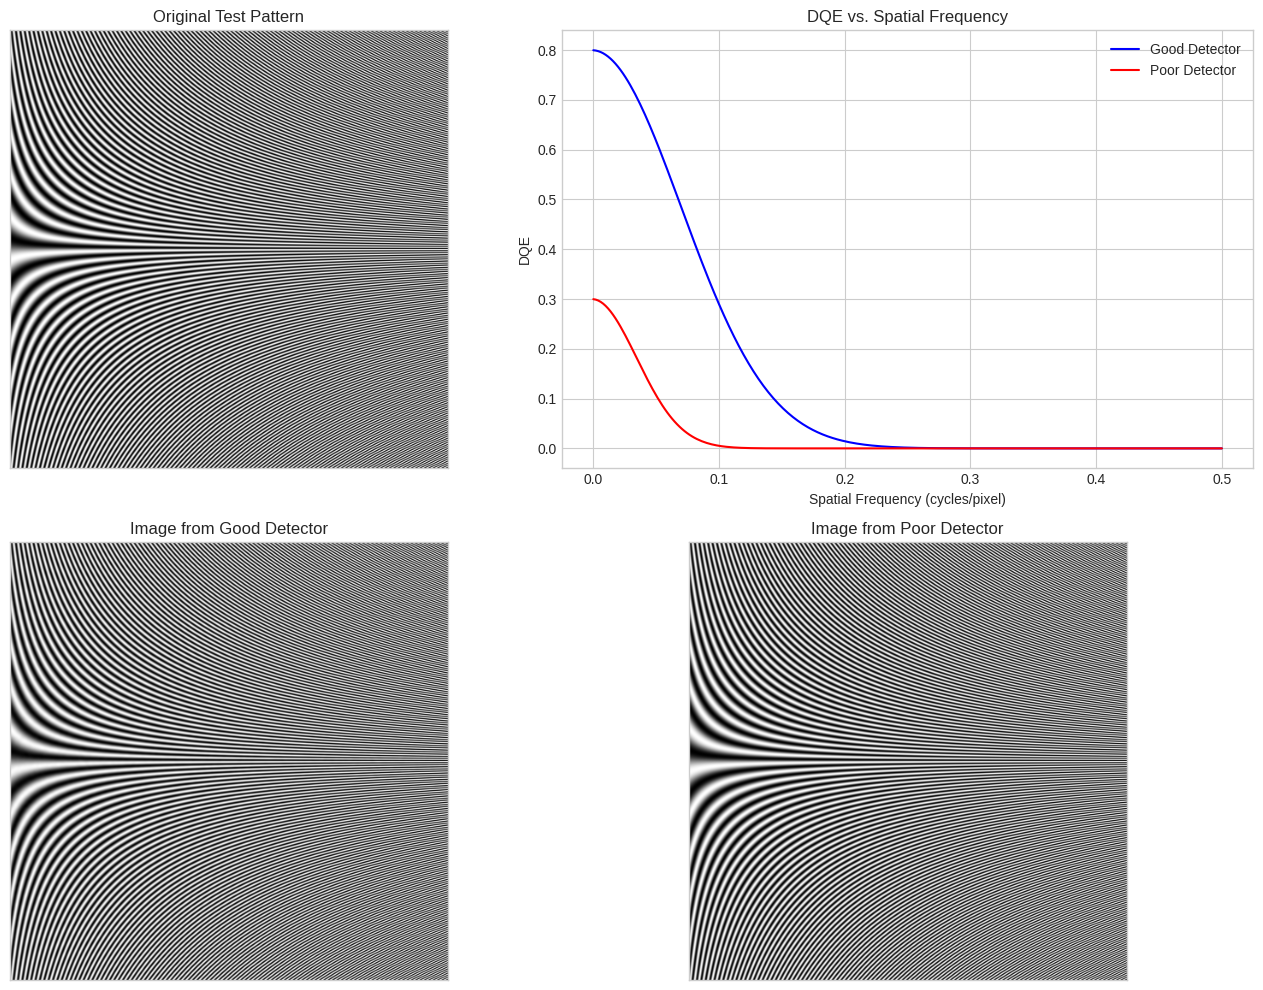

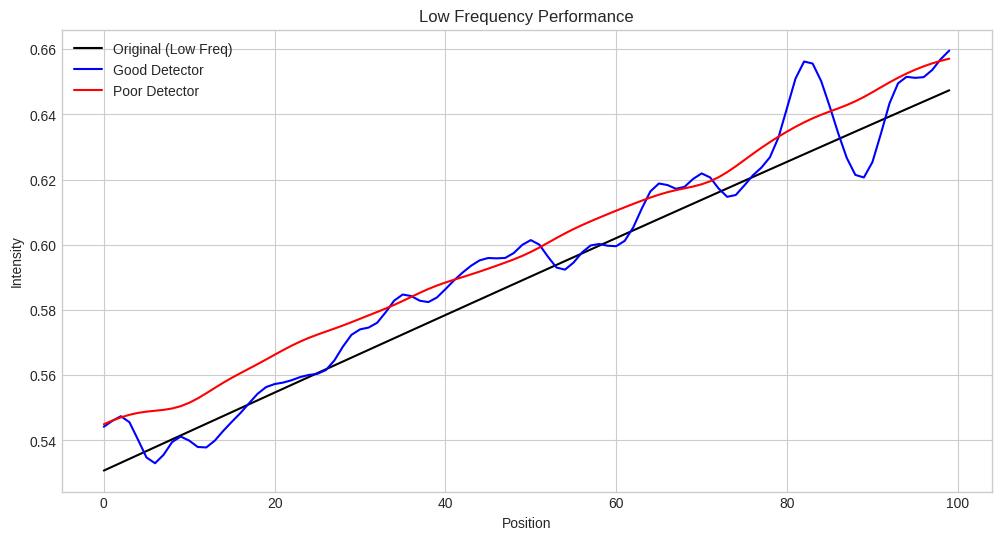

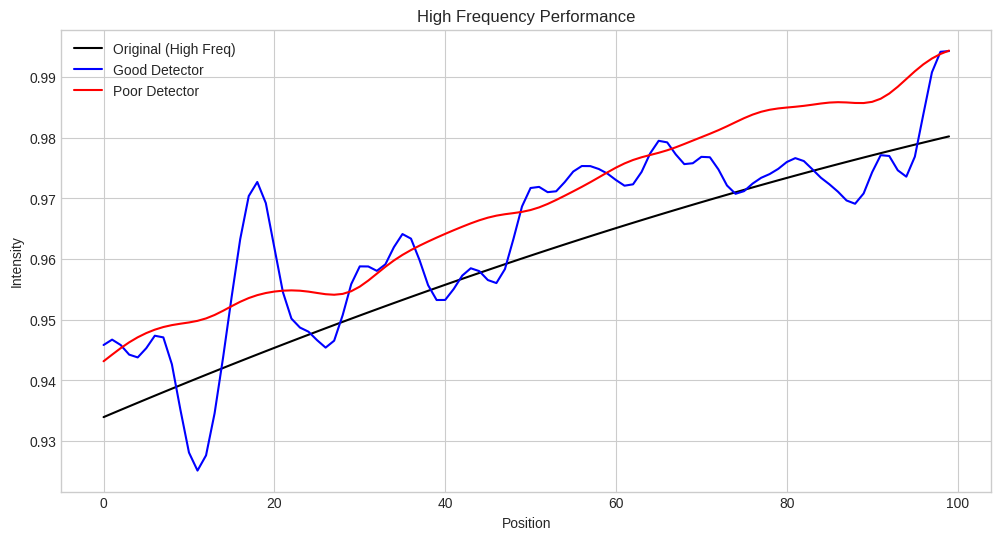

In real detectors, DQE varies with spatial frequency.
Most detectors have higher DQE at low frequencies (large features).
DQE drops at higher frequencies (fine details).

A good detector maintains higher DQE across the frequency spectrum.
This allows it to capture both large features and fine details accurately.
The frequency at which DQE drops to 0.5 is often used as a performance metric.


In [12]:
# 5. Frequency-Dependent DQE

def simulate_frequency_dependent_dqe():
    """Demonstrate how DQE varies with spatial frequency"""
    
    # Create a test pattern with a range of spatial frequencies
    size = 512
    x = np.linspace(-10, 10, size)
    y = np.linspace(-10, 10, size)
    X, Y = np.meshgrid(x, y)
    
    # Create a pattern that has increasing frequency from left to right
    test_pattern = np.zeros((size, size))
    for i in range(size):
        frequency = 0.5 + (i / size) * 10  # frequency increases with column index
        test_pattern[:, i] = 0.5 + 0.5 * np.sin(2 * np.pi * frequency * y)
    
    # Apply a realistic frequency-dependent DQE
    def apply_frequency_dependent_dqe(image, dose=100):
        """Apply realistic frequency-dependent DQE"""
        # Convert to frequency domain
        img_freq = fftshift(fft2(image))
        
        # Create frequency-dependent DQE function
        freq_x = np.linspace(-0.5, 0.5, size)
        freq_y = np.linspace(-0.5, 0.5, size)
        FX, FY = np.meshgrid(freq_x, freq_y)
        freq_radius = np.sqrt(FX**2 + FY**2)
        
        # Good DQE detector: high at low frequencies, gradually drops
        dqe_good = 0.8 * np.exp(-(freq_radius**2) / 0.1**2)
        
        # Poor DQE detector: lower overall, drops quickly
        dqe_poor = 0.3 * np.exp(-(freq_radius**2) / 0.05**2)
        
        # Apply Poisson noise in frequency domain (simplified)
        noise_factor_good = np.sqrt(dose * dqe_good) / dose
        noise_factor_poor = np.sqrt(dose * dqe_poor) / dose
        
        # Add frequency-dependent noise
        noise_good = np.random.normal(0, noise_factor_good, img_freq.shape)
        noise_poor = np.random.normal(0, noise_factor_poor, img_freq.shape)
        
        # Combine signal and noise
        img_freq_good = img_freq + noise_good * np.abs(img_freq)
        img_freq_poor = img_freq + noise_poor * np.abs(img_freq)
        
        # Transform back to spatial domain
        result_good = np.real(ifft2(ifftshift(img_freq_good)))
        result_poor = np.real(ifft2(ifftshift(img_freq_poor)))
        
        return result_good, result_poor, dqe_good, dqe_poor
    
    # Apply DQE simulation
    result_good, result_poor, dqe_good, dqe_poor = apply_frequency_dependent_dqe(test_pattern)
    
    # Plot results
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # Original pattern
    axs[0, 0].imshow(test_pattern, cmap='gray')
    axs[0, 0].set_title('Original Test Pattern')
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticks([])
    
    # DQE curves
    center = size // 2
    freq_x = np.linspace(0, 0.5, size//2)
    axs[0, 1].plot(freq_x, dqe_good[center, center:center+size//2], 'b-', label='Good Detector')
    axs[0, 1].plot(freq_x, dqe_poor[center, center:center+size//2], 'r-', label='Poor Detector')
    axs[0, 1].set_title('DQE vs. Spatial Frequency')
    axs[0, 1].set_xlabel('Spatial Frequency (cycles/pixel)')
    axs[0, 1].set_ylabel('DQE')
    axs[0, 1].legend()
    axs[0, 1].grid(True)
    
    # Simulated images
    axs[1, 0].imshow(result_good, cmap='gray')
    axs[1, 0].set_title('Image from Good Detector')
    axs[1, 0].set_xticks([])
    axs[1, 0].set_yticks([])
    
    axs[1, 1].imshow(result_poor, cmap='gray')
    axs[1, 1].set_title('Image from Poor Detector')
    axs[1, 1].set_xticks([])
    axs[1, 1].set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    # Plot 1D profiles to better see the effect
    plt.figure(figsize=(12, 6))
    row = size // 2
    plt.plot(test_pattern[row, :100], 'k-', label='Original (Low Freq)')
    plt.plot(result_good[row, :100], 'b-', label='Good Detector')
    plt.plot(result_poor[row, :100], 'r-', label='Poor Detector')
    plt.legend()
    plt.title('Low Frequency Performance')
    plt.xlabel('Position')
    plt.ylabel('Intensity')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(test_pattern[row, -100:], 'k-', label='Original (High Freq)')
    plt.plot(result_good[row, -100:], 'b-', label='Good Detector')
    plt.plot(result_poor[row, -100:], 'r-', label='Poor Detector')
    plt.legend()
    plt.title('High Frequency Performance')
    plt.xlabel('Position')
    plt.ylabel('Intensity')
    plt.show()
    
    print("In real detectors, DQE varies with spatial frequency.")
    print("Most detectors have higher DQE at low frequencies (large features).")
    print("DQE drops at higher frequencies (fine details).")
    print("\nA good detector maintains higher DQE across the frequency spectrum.")
    print("This allows it to capture both large features and fine details accurately.")
    print("The frequency at which DQE drops to 0.5 is often used as a performance metric.")

# Execute the function
simulate_frequency_dependent_dqe()

/tmp/ipykernel_296225/3795020690.py:58: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/home/lpetrov/projects/sandbox/mtf_dqe/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


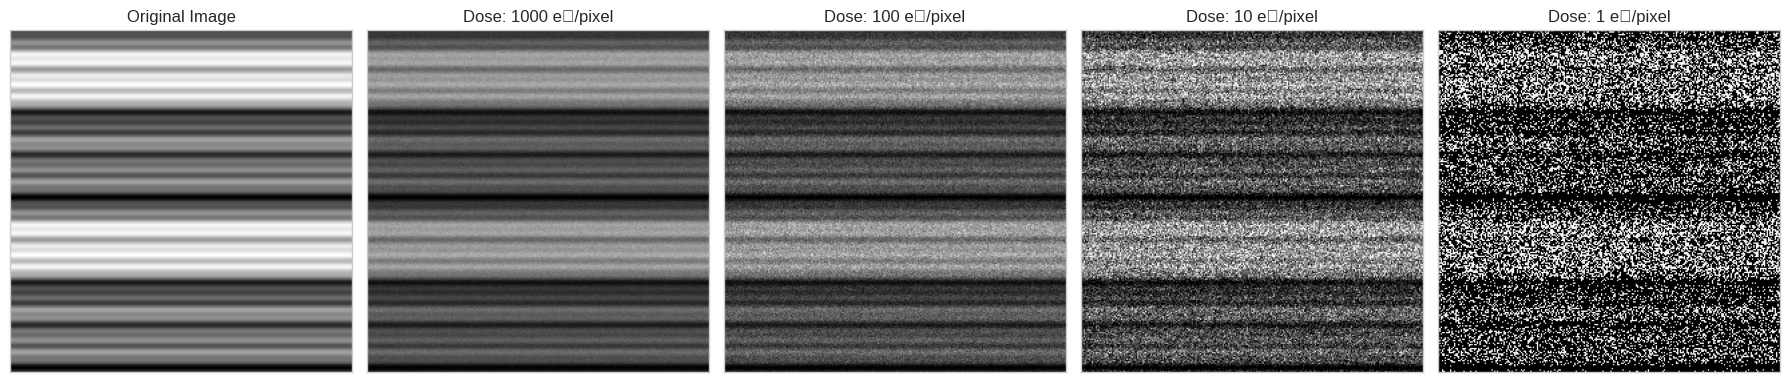

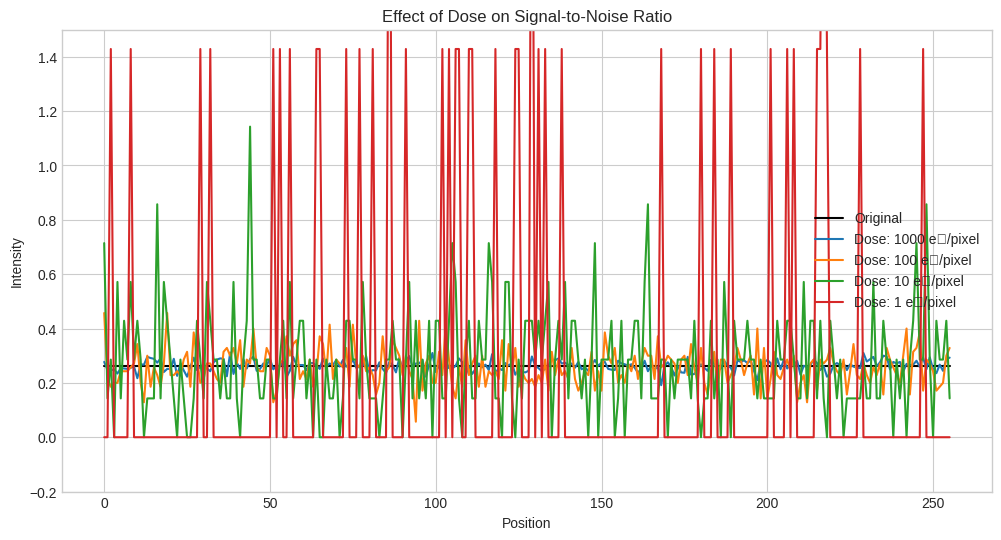

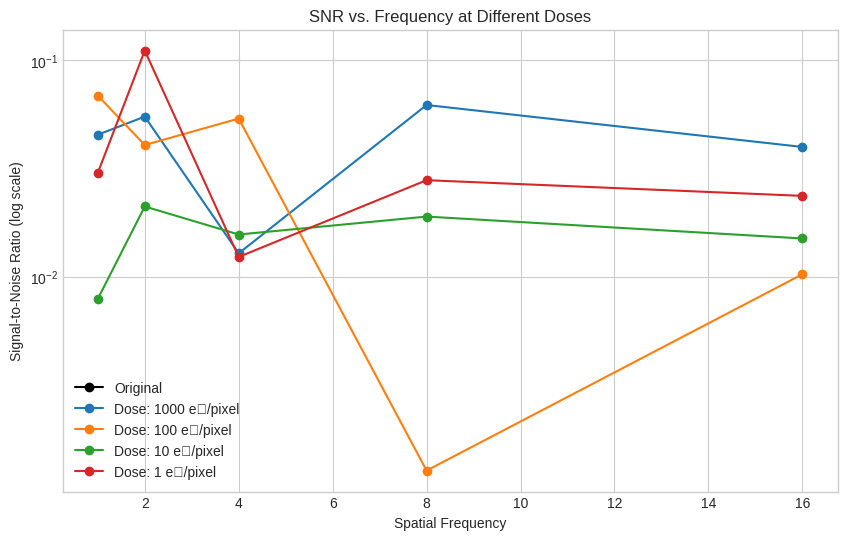

The resolution-dose tradeoff is fundamental in electron microscopy:
- Higher doses provide better SNR but can damage beam-sensitive samples
- Lower doses preserve the sample but result in noisier images
- Higher frequencies (finer details) require higher doses to achieve acceptable SNR

This is why cryo-EM and other low-dose techniques require:
1. High DQE detectors to maximize efficiency
2. Averaging multiple images to improve SNR
3. Optimal image processing to extract information from noisy data


In [13]:
# 6. Practical Implications: Resolution vs. Dose (continued)
def explore_resolution_dose_tradeoff():
    """Explore the practical tradeoff between resolution and dose"""
    
    # Create a simple test image with fine details
    size = 256
    test_image = np.zeros((size, size))
    
    # Add features of different sizes
    for i in range(5):
        frequency = 2**(i+1)  # Increasing frequencies
        phase = np.random.rand() * 2 * np.pi  # Random phase
        x = np.linspace(0, 2*np.pi, size)
        pattern = np.sin(frequency * x + phase)
        test_image += np.outer(pattern, np.ones(size)) * (0.8 ** i)  # Decreasing contrast
    
    # Normalize
    test_image = (test_image - np.min(test_image)) / (np.max(test_image) - np.min(test_image))
    
    # Define different electron doses
    doses = [1000, 100, 10, 1]  # electrons/pixel
    
    def simulate_imaging(image, dose, dqe=0.5):
        """Simulate electron microscopy image formation"""
        # Scale image to represent electron counts
        scaled_image = image * dose
        
        # Apply Poisson noise (electron counting statistics)
        detected_electrons = poisson(scaled_image * dqe)
        
        # Normalize back
        result = detected_electrons / (dose * dqe)
        
        return result
    
    # Apply different doses
    results = []
    for dose in doses:
        result = simulate_imaging(test_image, dose, dqe=0.7)
        results.append(result)
    
    # Plot results
    fig, axs = plt.subplots(1, 5, figsize=(18, 6))
    
    # Original image
    axs[0].imshow(test_image, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    
    # Images at different doses
    for i, (dose, result) in enumerate(zip(doses, results)):
        axs[i+1].imshow(result, cmap='gray', vmin=0, vmax=1.5)
        axs[i+1].set_title(f'Dose: {dose} e⁻/pixel')
        axs[i+1].set_xticks([])
        axs[i+1].set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    # Plot line profiles
    plt.figure(figsize=(12, 6))
    row = size // 2
    plt.plot(test_image[row, :], 'k-', label='Original')
    
    for dose, result in zip(doses, results):
        plt.plot(result[row, :], label=f'Dose: {dose} e⁻/pixel')
    
    plt.legend()
    plt.title('Effect of Dose on Signal-to-Noise Ratio')
    plt.xlabel('Position')
    plt.ylabel('Intensity')
    plt.ylim(-0.2, 1.5)
    plt.show()
    
    # Calculate SNR at different frequencies and doses
    def calculate_frequency_snr(images, frequencies=[1, 2, 4, 8, 16]):
        """Calculate SNR at different frequencies"""
        snrs = []
        
        # Create reference signals at different frequencies
        size = images[0].shape[0]
        x = np.linspace(0, 2*np.pi, size)
        
        for freq in frequencies:
            signal = np.sin(freq * x)
            
            # Calculate SNR for each image
            image_snrs = []
            for img in images:
                # Extract row from middle of image
                row = size // 2
                profile = img[row, :]
                
                # Calculate correlation with reference signal
                corr = np.abs(np.sum(profile * signal)) / size
                
                # Calculate noise level (standard deviation)
                noise = np.std(profile - np.mean(profile))
                
                # SNR
                snr = corr / noise if noise > 0 else float('inf')
                image_snrs.append(snr)
            
            snrs.append(image_snrs)
        
        return np.array(snrs)
    
    # Calculate SNR at different frequencies and doses
    frequencies = [1, 2, 4, 8, 16]
    snrs = calculate_frequency_snr([test_image] + results, frequencies)
    
    # Plot SNR vs Frequency for different doses
    plt.figure(figsize=(10, 6))
    
    plt.plot(frequencies, snrs[:, 0], 'k-o', label='Original')
    for i, dose in enumerate(doses):
        plt.plot(frequencies, snrs[:, i+1], '-o', label=f'Dose: {dose} e⁻/pixel')
    
    plt.xlabel('Spatial Frequency')
    plt.ylabel('Signal-to-Noise Ratio (log scale)')
    plt.title('SNR vs. Frequency at Different Doses')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.show()
    
    print("The resolution-dose tradeoff is fundamental in electron microscopy:")
    print("- Higher doses provide better SNR but can damage beam-sensitive samples")
    print("- Lower doses preserve the sample but result in noisier images")
    print("- Higher frequencies (finer details) require higher doses to achieve acceptable SNR")
    print("\nThis is why cryo-EM and other low-dose techniques require:")
    print("1. High DQE detectors to maximize efficiency")
    print("2. Averaging multiple images to improve SNR")
    print("3. Optimal image processing to extract information from noisy data")

# Execute the function
explore_resolution_dose_tradeoff()

Practical MTF Measurement Methods:
1. Knife-Edge Method:
   - Image a sharp edge
   - Extract Edge Spread Function (ESF)
   - Differentiate to get Line Spread Function (LSF)
   - Take FFT of LSF to get MTF

2. Noise Power Spectrum Method:
   - Acquire flat-field images (uniform illumination)
   - Calculate power spectrum of noise
   - MTF² = NPS_out / NPS_in (under certain assumptions)

3. Slanted Edge Method (ISO 12233):
   - Image a slightly slanted edge (a few degrees)
   - Allows super-resolution sampling of the edge
   - Extract ESF, then proceed as with knife-edge

Practical DQE Measurement Methods:
1. Basic Definition Method:
   - DQE(f) = SNR_out²(f) / SNR_in²(f)
   - Requires measuring input and output SNR at each frequency

2. Practical Formula:
   - DQE(f) = MTF²(f) / (NPS(f) * q)
   - where q is the input quanta per unit area
   - MTF(f) is the modulation transfer function
   - NPS(f) is the normalized noise power spectrum


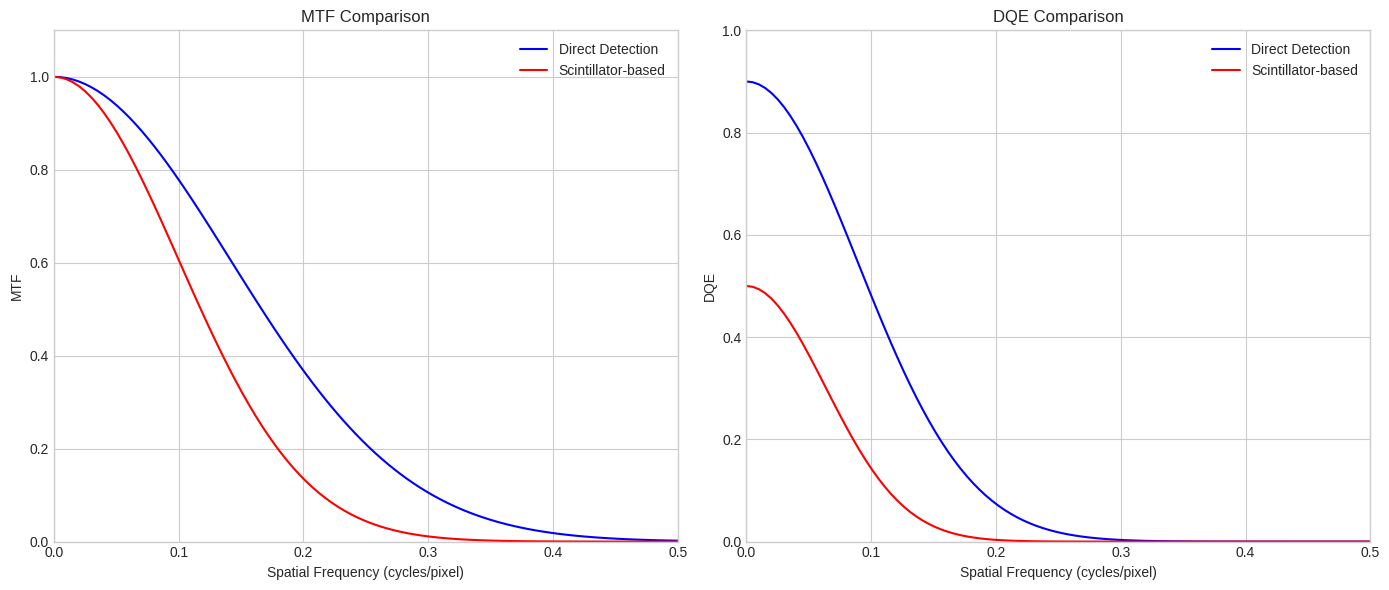


Modern Detector Technology Comparison:
1. Direct Electron Detectors (DED):
   - Electrons directly strike semiconductor
   - Minimal scattering/spreading of signal
   - Better MTF, especially at high frequencies
   - Higher DQE across all frequencies
   - Examples: Gatan K2/K3, Falcon, DE-series

2. Scintillator-based Detectors:
   - Electrons strike scintillator, producing light
   - Light is detected by CCD or CMOS sensor
   - Light spreading degrades MTF
   - Lower DQE, especially at high frequencies
   - Examples: Traditional CCD cameras

3. Counting vs. Integrating Mode:
   - Counting: Individual electrons detected and counted
   - Better DQE but limited count rate
   - Integrating: Total charge measured
   - Can handle higher dose rates but lower DQE
   - Super-resolution: Localize impact position within pixel


In [14]:
# 7. Practical MTF and DQE Measurement

def practical_mtf_dqe_measurement():
    """Demonstrate practical methods for measuring MTF and DQE"""
    
    print("Practical MTF Measurement Methods:")
    print("1. Knife-Edge Method:")
    print("   - Image a sharp edge")
    print("   - Extract Edge Spread Function (ESF)")
    print("   - Differentiate to get Line Spread Function (LSF)")
    print("   - Take FFT of LSF to get MTF")
    print("\n2. Noise Power Spectrum Method:")
    print("   - Acquire flat-field images (uniform illumination)")
    print("   - Calculate power spectrum of noise")
    print("   - MTF² = NPS_out / NPS_in (under certain assumptions)")
    print("\n3. Slanted Edge Method (ISO 12233):")
    print("   - Image a slightly slanted edge (a few degrees)")
    print("   - Allows super-resolution sampling of the edge")
    print("   - Extract ESF, then proceed as with knife-edge")
    
    print("\nPractical DQE Measurement Methods:")
    print("1. Basic Definition Method:")
    print("   - DQE(f) = SNR_out²(f) / SNR_in²(f)")
    print("   - Requires measuring input and output SNR at each frequency")
    print("\n2. Practical Formula:")
    print("   - DQE(f) = MTF²(f) / (NPS(f) * q)")
    print("   - where q is the input quanta per unit area")
    print("   - MTF(f) is the modulation transfer function")
    print("   - NPS(f) is the normalized noise power spectrum")
    
    # Create a simulated MTF and DQE curve for a typical detector
    frequencies = np.linspace(0, 0.5, 100)  # Nyquist frequency = 0.5
    
    # Different MTF models
    mtf_direct = np.exp(-(frequencies**2) / 0.04)  # Direct detection
    mtf_scintillator = np.exp(-(frequencies**2) / 0.02)  # Scintillator-based
    
    # DQE models based on MTF and other factors
    dqe_direct = mtf_direct**2 * (0.9 * np.exp(-(frequencies**2) / 0.08))
    dqe_scintillator = mtf_scintillator**2 * (0.5 * np.exp(-(frequencies**2) / 0.04))
    
    # Plot MTF and DQE curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # MTF plot
    ax1.plot(frequencies, mtf_direct, 'b-', label='Direct Detection')
    ax1.plot(frequencies, mtf_scintillator, 'r-', label='Scintillator-based')
    ax1.set_title('MTF Comparison')
    ax1.set_xlabel('Spatial Frequency (cycles/pixel)')
    ax1.set_ylabel('MTF')
    ax1.legend()
    ax1.grid(True)
    ax1.set_xlim(0, 0.5)
    ax1.set_ylim(0, 1.1)
    
    # DQE plot
    ax2.plot(frequencies, dqe_direct, 'b-', label='Direct Detection')
    ax2.plot(frequencies, dqe_scintillator, 'r-', label='Scintillator-based')
    ax2.set_title('DQE Comparison')
    ax2.set_xlabel('Spatial Frequency (cycles/pixel)')
    ax2.set_ylabel('DQE')
    ax2.legend()
    ax2.grid(True)
    ax2.set_xlim(0, 0.5)
    ax2.set_ylim(0, 1.0)
    
    plt.tight_layout()
    plt.show()
    
    print("\nModern Detector Technology Comparison:")
    print("1. Direct Electron Detectors (DED):")
    print("   - Electrons directly strike semiconductor")
    print("   - Minimal scattering/spreading of signal")
    print("   - Better MTF, especially at high frequencies")
    print("   - Higher DQE across all frequencies")
    print("   - Examples: Gatan K2/K3, Falcon, DE-series")
    print("\n2. Scintillator-based Detectors:")
    print("   - Electrons strike scintillator, producing light")
    print("   - Light is detected by CCD or CMOS sensor")
    print("   - Light spreading degrades MTF")
    print("   - Lower DQE, especially at high frequencies")
    print("   - Examples: Traditional CCD cameras")
    print("\n3. Counting vs. Integrating Mode:")
    print("   - Counting: Individual electrons detected and counted")
    print("   - Better DQE but limited count rate")
    print("   - Integrating: Total charge measured")
    print("   - Can handle higher dose rates but lower DQE")
    print("   - Super-resolution: Localize impact position within pixel")

# Execute the function
practical_mtf_dqe_measurement()

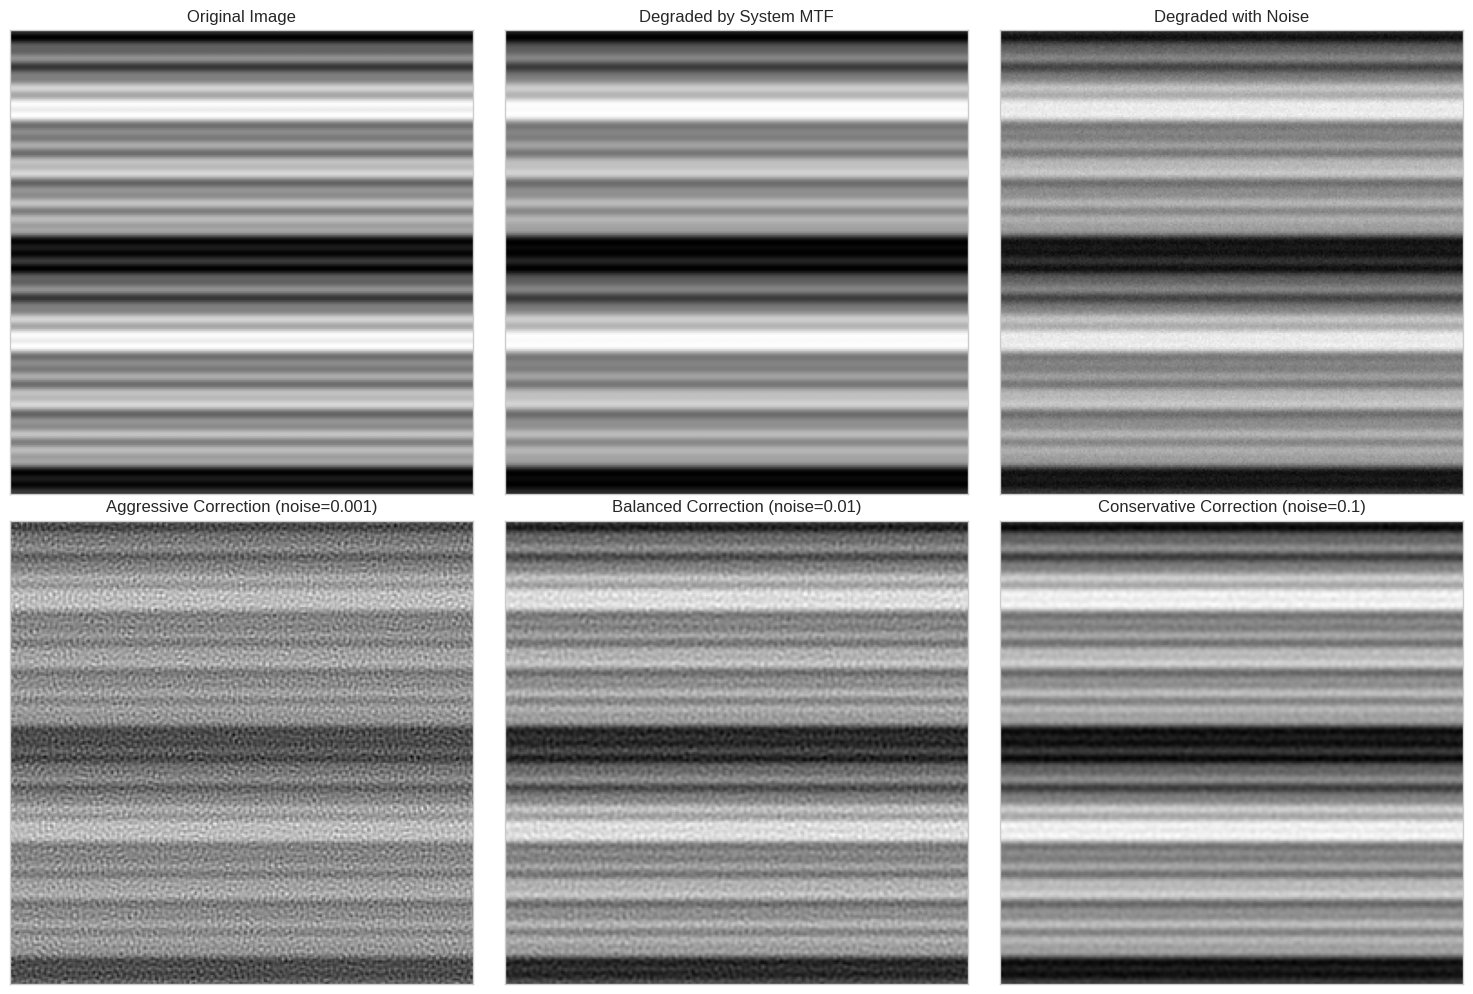

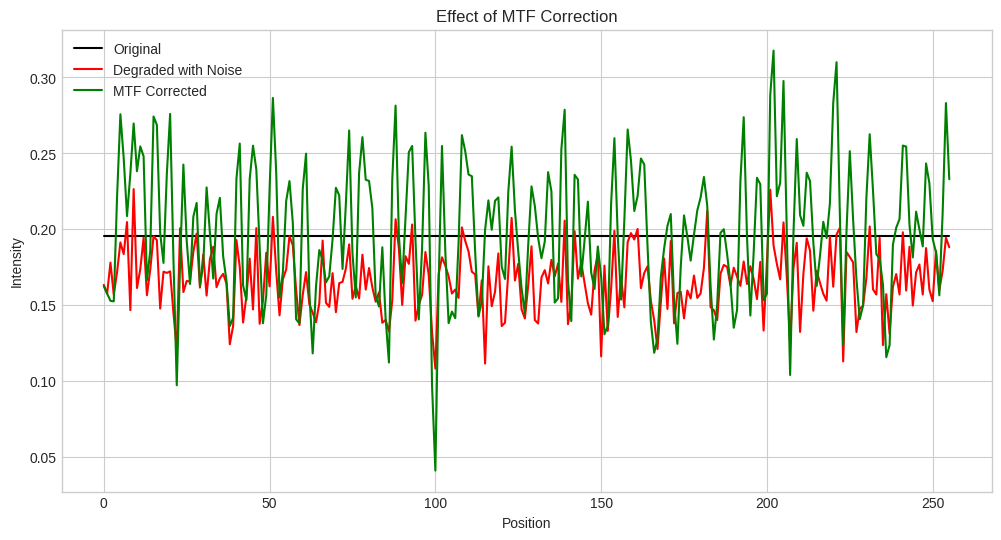

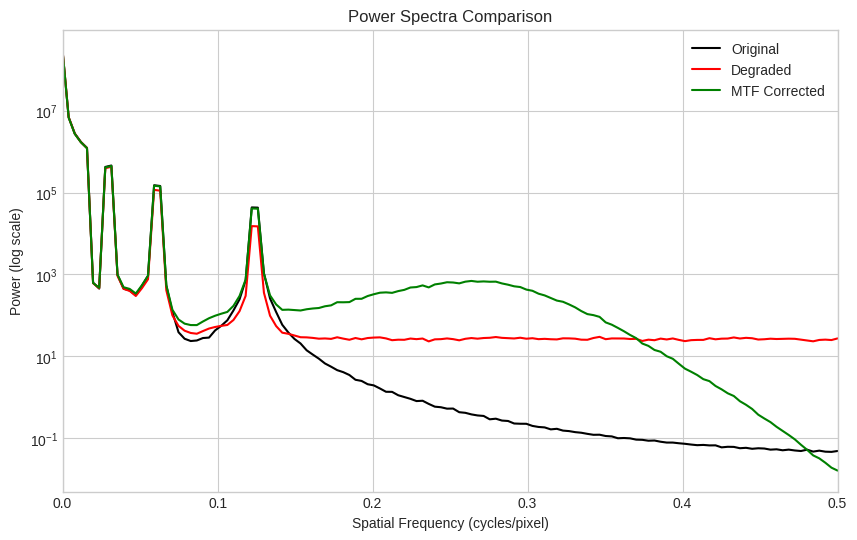

MTF Correction can improve effective resolution:
1. The system MTF attenuates high frequencies (fine details)
2. MTF correction boosts these frequencies back up
3. However, noise is also amplified, creating a tradeoff

The Wiener filter optimizes this tradeoff:
- Less aggressive in regions where noise dominates signal
- More aggressive where signal is strong
- The 'noise level' parameter controls the balance

In practice, MTF correction is part of a complete image processing workflow:
- Motion correction
- CTF (Contrast Transfer Function) estimation and correction
- MTF correction
- Noise filtering/denoising
- Particle picking/feature detection


In [15]:
# 8. Case Study: Resolution Improvement through MTF Correction

def mtf_correction_demo():
    """Demonstrate how MTF correction can improve effective resolution"""
    
    # Create a test image with fine details
    size = 256
    test_image = np.zeros((size, size))
    
    # Add features of different sizes
    for i in range(5):
        frequency = 2**(i+1)  # Increasing frequencies
        phase = np.random.rand() * 2 * np.pi  # Random phase
        x = np.linspace(0, 2*np.pi, size)
        pattern = np.sin(frequency * x + phase)
        test_image += np.outer(pattern, np.ones(size)) * (0.8 ** i)  # Decreasing contrast
    
    # Normalize
    test_image = (test_image - np.min(test_image)) / (np.max(test_image) - np.min(test_image))
    
    # Define system MTF
    def create_system_mtf(size):
        """Create system MTF (Gaussian model)"""
        freq_x = np.linspace(-0.5, 0.5, size)
        freq_y = np.linspace(-0.5, 0.5, size)
        FX, FY = np.meshgrid(freq_x, freq_y)
        freq_radius = np.sqrt(FX**2 + FY**2)
        
        # Gaussian MTF model
        mtf = np.exp(-(freq_radius**2) / 0.03)
        return mtf
    
    # Apply system MTF to degrade image
    def apply_mtf(image, mtf):
        """Apply MTF to image in frequency domain"""
        # Transform to frequency domain
        img_freq = fftshift(fft2(image))
        
        # Apply MTF
        img_freq_degraded = img_freq * mtf
        
        # Transform back to spatial domain
        result = np.real(ifft2(ifftshift(img_freq_degraded)))
        
        return result
    
    # Create MTF for the system
    system_mtf = create_system_mtf(size)
    
    # Degrade image with system MTF
    degraded_image = apply_mtf(test_image, system_mtf)
    
    # Add noise to simulate realistic conditions
    degraded_noisy = degraded_image + np.random.normal(0, 0.02, degraded_image.shape)
    
    # Define Wiener filter for MTF correction
    def mtf_correction_wiener(image, mtf, noise_level=0.01):
        """Apply Wiener filter for MTF correction"""
        # Transform to frequency domain
        img_freq = fftshift(fft2(image))
        
        # Wiener filter
        wiener_filter = np.conj(mtf) / (np.abs(mtf)**2 + noise_level)
        
        # Apply filter
        img_freq_corrected = img_freq * wiener_filter
        
        # Transform back to spatial domain
        result = np.real(ifft2(ifftshift(img_freq_corrected)))
        
        return result
    
    # Apply MTF correction with different noise parameter values
    corrected_low = mtf_correction_wiener(degraded_noisy, system_mtf, noise_level=0.001)
    corrected_medium = mtf_correction_wiener(degraded_noisy, system_mtf, noise_level=0.01)
    corrected_high = mtf_correction_wiener(degraded_noisy, system_mtf, noise_level=0.1)
    
    # Plot results
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original and degraded images
    axs[0, 0].imshow(test_image, cmap='gray')
    axs[0, 0].set_title('Original Image')
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticks([])
    
    axs[0, 1].imshow(degraded_image, cmap='gray')
    axs[0, 1].set_title('Degraded by System MTF')
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])
    
    axs[0, 2].imshow(degraded_noisy, cmap='gray')
    axs[0, 2].set_title('Degraded with Noise')
    axs[0, 2].set_xticks([])
    axs[0, 2].set_yticks([])
    
    # Corrected images with different parameters
    axs[1, 0].imshow(corrected_low, cmap='gray')
    axs[1, 0].set_title('Aggressive Correction (noise=0.001)')
    axs[1, 0].set_xticks([])
    axs[1, 0].set_yticks([])
    
    axs[1, 1].imshow(corrected_medium, cmap='gray')
    axs[1, 1].set_title('Balanced Correction (noise=0.01)')
    axs[1, 1].set_xticks([])
    axs[1, 1].set_yticks([])
    
    axs[1, 2].imshow(corrected_high, cmap='gray')
    axs[1, 2].set_title('Conservative Correction (noise=0.1)')
    axs[1, 2].set_xticks([])
    axs[1, 2].set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    # Plot line profiles for comparison
    plt.figure(figsize=(12, 6))
    row = size // 2
    plt.plot(test_image[row, :], 'k-', label='Original')
    plt.plot(degraded_noisy[row, :], 'r-', label='Degraded with Noise')
    plt.plot(corrected_medium[row, :], 'g-', label='MTF Corrected')
    plt.legend()
    plt.title('Effect of MTF Correction')
    plt.xlabel('Position')
    plt.ylabel('Intensity')
    plt.show()
    
    # Calculate and plot power spectra
    def calculate_power_spectrum(image):
        """Calculate radially averaged power spectrum"""
        # Calculate 2D power spectrum
        ps2d = np.abs(fftshift(fft2(image)))**2
        
        # Create radius coordinates
        y, x = np.indices(ps2d.shape)
        center = np.array([(x.max() - x.min()) / 2.0, (y.max() - y.min()) / 2.0])
        r = np.hypot(x - center[0], y - center[1])
        
        # Convert to integer indices
        r = r.astype(int)
        
        # Sum over radius bins
        tbin = np.bincount(r.ravel(), ps2d.ravel())
        nr = np.bincount(r.ravel())
        radial_ps = tbin / nr
        
        return radial_ps[:size//2]
    
    # Calculate power spectra
    ps_original = calculate_power_spectrum(test_image)
    ps_degraded = calculate_power_spectrum(degraded_noisy)
    ps_corrected = calculate_power_spectrum(corrected_medium)
    
    # Plot power spectra
    plt.figure(figsize=(10, 6))
    freq = np.linspace(0, 0.5, len(ps_original))
    plt.semilogy(freq, ps_original, 'k-', label='Original')
    plt.semilogy(freq, ps_degraded, 'r-', label='Degraded')
    plt.semilogy(freq, ps_corrected, 'g-', label='MTF Corrected')
    plt.legend()
    plt.title('Power Spectra Comparison')
    plt.xlabel('Spatial Frequency (cycles/pixel)')
    plt.ylabel('Power (log scale)')
    plt.grid(True)
    plt.xlim(0, 0.5)
    plt.show()
    
    print("MTF Correction can improve effective resolution:")
    print("1. The system MTF attenuates high frequencies (fine details)")
    print("2. MTF correction boosts these frequencies back up")
    print("3. However, noise is also amplified, creating a tradeoff")
    print("\nThe Wiener filter optimizes this tradeoff:")
    print("- Less aggressive in regions where noise dominates signal")
    print("- More aggressive where signal is strong")
    print("- The 'noise level' parameter controls the balance")
    print("\nIn practice, MTF correction is part of a complete image processing workflow:")
    print("- Motion correction")
    print("- CTF (Contrast Transfer Function) estimation and correction")
    print("- MTF correction")
    print("- Noise filtering/denoising")
    print("- Particle picking/feature detection")

# Execute the function
mtf_correction_demo()

In [16]:
# 9. Conclusion and Practical Considerations

def conclusion():
    """Summarize key points and practical considerations"""
    
    print("Key Takeaways:")
    print("\n1. MTF (Modulation Transfer Function):")
    print("   - Measures how faithfully an imaging system transfers contrast across spatial frequencies")
    print("   - Lower MTF at higher frequencies means loss of fine details")
    print("   - Can be measured using knife-edge, slanted edge, or noise power spectrum methods")
    print("   - MTF correction can restore some lost resolution but amplifies noise")
    
    print("\n2. DQE (Detective Quantum Efficiency):")
    print("   - Measures detector's efficiency in converting input signal (electrons) to useful output")
    print("   - DQE = (SNR_out²) / (SNR_in²)")
    print("   - Frequency-dependent: typically highest at low frequencies")
    print("   - Critical for low-dose imaging (beam-sensitive specimens)")
    
    print("\n3. Resolution-Dose Tradeoff:")
    print("   - Higher resolution (finer details) requires higher dose")
    print("   - But higher dose damages sensitive specimens")
    print("   - High DQE detectors help minimize this tradeoff")
    print("   - Image averaging and processing can further improve SNR")
    
    print("\n4. Modern Detection Technologies:")
    print("   - Direct electron detectors offer superior MTF and DQE")
    print("   - Counting mode provides better DQE but limited count rate")
    print("   - Super-resolution can overcome Nyquist limit by localizing impact position")
    
    print("\n5. Practical Considerations:")
    print("   - Know your detector's MTF and DQE characteristics")
    print("   - Balance dose with sample damage considerations")
    print("   - Choose appropriate defocus for phase contrast")
    print("   - Consider frame-alignment for motion correction")
    print("   - Apply appropriate image processing (CTF correction, MTF correction, denoising)")
    
    print("\nFurther Learning Resources:")
    print("1. Textbooks:")
    print("   - 'Transmission Electron Microscopy' by Williams & Carter")
    print("   - 'Electron Microscopy: Principles and Techniques for Biologists' by Bozzola & Russell")
    
    print("\n2. Research Papers:")
    print("   - McMullan et al. 'Comparison of optimal performance at 300 keV of three direct electron detectors for use in low dose electron microscopy'")
    print("   - Ruskin et al. 'Quantitative Characterization of Electron Detectors for Transmission Electron Microscopy'")
    
    print("\n3. Software and Tools:")
    print("   - CTFFIND4: CTF estimation")
    print("   - MotionCor2: Motion correction")
    print("   - RELION, cryoSPARC: Image processing pipelines for single-particle analysis")
    print("   - ImageJ/Fiji: General image analysis with TEM plugins")
    
    print("\nPractical Exercises:")
    print("1. Measure your microscope's MTF using the knife-edge method")
    print("2. Evaluate how SNR changes with dose in your system")
    print("3. Compare images before and after MTF correction")
    print("4. Explore the effect of defocus on contrast and resolution")

# Execute the conclusion
conclusion()

Key Takeaways:

1. MTF (Modulation Transfer Function):
   - Measures how faithfully an imaging system transfers contrast across spatial frequencies
   - Lower MTF at higher frequencies means loss of fine details
   - Can be measured using knife-edge, slanted edge, or noise power spectrum methods
   - MTF correction can restore some lost resolution but amplifies noise

2. DQE (Detective Quantum Efficiency):
   - Measures detector's efficiency in converting input signal (electrons) to useful output
   - DQE = (SNR_out²) / (SNR_in²)
   - Frequency-dependent: typically highest at low frequencies
   - Critical for low-dose imaging (beam-sensitive specimens)

3. Resolution-Dose Tradeoff:
   - Higher resolution (finer details) requires higher dose
   - But higher dose damages sensitive specimens
   - High DQE detectors help minimize this tradeoff
   - Image averaging and processing can further improve SNR

4. Modern Detection Technologies:
   - Direct electron detectors offer superior MTF and